# 1 探索数据
认识数据集

# 创建新的数据结构
1、json 是个啥  
2、lambda函数  
3、apply  
4、定义函数

In [1]:
import json
import pandas as pd

def load_tmdb_movies(path):
    df = pd.read_csv(path)
    df["release_date"] = pd.to_datetime(df['release_date']).apply(lambda x: x.date())
    json_columns = ['genres', 'keywords', 'production_countries', 'production_companies', 'spoken_languages']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df

def load_tmdb_credits(path):
    df = pd.read_csv(path)
    json_columns = ['cast', 'crew']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df

LOSTS_COLUMNS = [
    'actor_1_facebook_likes', 
    'actor_2_facebook_likes', 
    'actor_3_facebook_likes', 
    'aspect_ratio', 
    'cast_total)facebook_likes', 
    'color', 
    'content_rating', 
    'director_facebook_like', 
    'facenumber_in_poster', 
    'movie_facebook_link', 
    'movie_imdb_link', 
    'num_critic_for_reviews', 
    'num_user_for_reviews']

TMDB_TO_IMDB_SIMPLE_EQUIVALENCIES ={
    'budget': 'budget',
    'genres': 'genres', 
    'revenue': 'gross',
    'title': 'movie_title',
    'runtime': 'duration',
    'original_language': 'language',
    'keywords': 'plot_keywords',
    'vote_count': 'num_voted_users'}

IMDB_COLUMNS_TO_REMAP = {'imdb_score': 'vote_average'}

def safe_access(container, index_values):
    #在索引或关键词缺失的时候返回空值，而不是错误
    result = container
    try:
        for idx in index_values:
            result = result[idx]
            return result
    except IndexError or KeyError:
        return pd.np.nan

def get_director(crew_data):
    directors = [x['name'] for x in crew_data if x['job'] == 'Director']
    return safe_access(directors, [0])

def pipe_flatten_names(keywords):
    return '|'.join(x['name'] for x in keywords)

def conver_to_original_format(movies, credits):
    tmdb_movies = movies.copy()
    tmdb_movies.rename(columns = TMDB_TO_IMDB_SIMPLE_EQUIVALENCIES, inplace=True)
    tmdb_movies['title_year'] = pd.to_datetime(tmdb_movies['release_date']).apply(lambda x: x.year)
    # I`m assuming that the first production country is equivalent, but have not been able to validate this
    tmdb_movies['country'] = tmdb_movies['production_countries'].apply(lambda x: safe_access(x, [0, 'name']))
    tmdb_movies['language'] = tmdb_movies['spoken_languages'].apply(lambda x: safe_access(x, [0, 'name']))
    tmdb_movies['director_name'] = credits['crew'].apply(get_director)
    tmdb_movies['actor_1_name'] = credits['cast'].apply(lambda x: safe_access(x, [1, 'name']))#iloc 与 直接[]的区别
    tmdb_movies['actor_2_name'] = credits['cast'].apply(lambda x: safe_access(x, [2, 'name']))
    tmdb_movies['actor_3_name'] = credits['cast'].apply(lambda x: safe_access(x, [3, 'name']))
    tmdb_movies['genres'] = tmdb_movies['genres'].apply(pipe_flatten_names)
    tmdb_movies['plot_keywords'] = tmdb_movies['plot_keywords'].apply(pipe_flatten_names)
    return tmdb_movies
    

# 查看数据是否在目录里


In [2]:
from subprocess import check_output
print(check_output(["ls","/home/hungery/Documents/Kaggle_competion/recommder system/"]).decode("utf-8"))

all.zip
tmdb_5000_credits.csv
tmdb_5000_movies.csv
tmdb_recommender_system.ipynb



In [3]:
import numpy as np
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import math, nltk, warnings
from nltk.corpus import wordnet
from sklearn import linear_model
from sklearn.neighbors import NearestNeighbors
from fuzzywuzzy import fuzz
from wordcloud import WordCloud, STOPWORDS

/home/hungery/anaconda3/lib/python3.6/site-packages/fuzzywuzzy/fuzz.py:35: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [4]:
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'last_expr'
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings('ignore')
PS = nltk.stem.PorterStemmer()

# 载入数据

In [5]:
credits = load_tmdb_credits("/home/hungery/Documents/Kaggle_competion/recommder system/tmdb_5000_credits.csv")
movies = load_tmdb_movies("/home/hungery/Documents/Kaggle_competion/recommder system/tmdb_5000_movies.csv")
df_initial = conver_to_original_format(movies, credits)
print("Shape:", df_initial.shape)

tab_info = pd.DataFrame(df_initial.dtypes).T.rename(index={0: 'column type'})
tab_info = tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0: 'null values'}))
tab_info = tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.rename(index={0: 'null values(%)'}))
tab_info

Shape: (4803, 26)


,budget,genres,homepage,id,plot_keywords,language,original_title,overview,popularity,production_companies,production_countries,release_date,gross,duration,spoken_languages,status,tagline,movie_title,vote_average,num_voted_users,title_year,country,director_name,actor_1_name,actor_2_name,actor_3_name
column type,int64,object,object,int64,object,object,object,object,float64,object,object,object,int64,float64,object,object,object,object,float64,int64,float64,object,object,object,object,object
null values,0,0,3091,0,0,86,0,3,0,0,0,1,0,2,0,0,844,0,0,0,1,174,30,53,63,93
null values(%),0,0,64.3556,0,0,1.79055,0,0.062461,0,0,0,0.0208203,0,0.0416406,0,0,17.5724,0,0,0,0.0208203,3.62274,0.62461,1.10348,1.31168,1.93629


# 1.1 keywords
假设：电影使用相同的关键字描述，那么内容就是一直的。  
1 set
2 isinstance
3 union

In [6]:
#列出所有关键字
set_keywords = set()
for liste_keywords in df_initial['plot_keywords'].str.split('|').values:
    if isinstance(liste_keywords, float):contiue #只有空值时才会有作用
    set_keywords = set_keywords.union(liste_keywords)
# 去掉空值连接，不去会是什么样子的？
set_keywords.remove('')

In [7]:
# 计算每个主题出现的次数，并按照频次降序排列
# 还会用于电影类型的探索
def count_word(df, ref_col, liste):
    keyword_count = dict()
    for s in liste:keyword_count[s] = 0
    for liste_keywords in df[ref_col].str.split('|'):
        if type(liste_keywords) == float and pd.isnull(liste_keywords):continue
        for s in [s for s in liste_keywords if s in liste]:
            if pd.notnull(s): keyword_count[s] += 1
# 将dict化为list，并按照频率排序
    keyword_occurences = []
    for k, v in keyword_count.items():
        keyword_occurences.append([k, v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

In [8]:
keyword_occurences, dum = count_word(df_initial, 'plot_keywords', set_keywords)
keyword_occurences[:5]

[['woman director', 324],
 ['independent film', 318],
 ['duringcreditsstinger', 307],
 ['based on novel', 197],
 ['murder', 189]]

# 词云与直方图
词云可以按照频数大小设计词的大小，并以图片的形式呈现  
直方图按照频数大小排列词，同时还能看到词的频率 这是词云无法做到的。  
1 词云  
2 figure用法

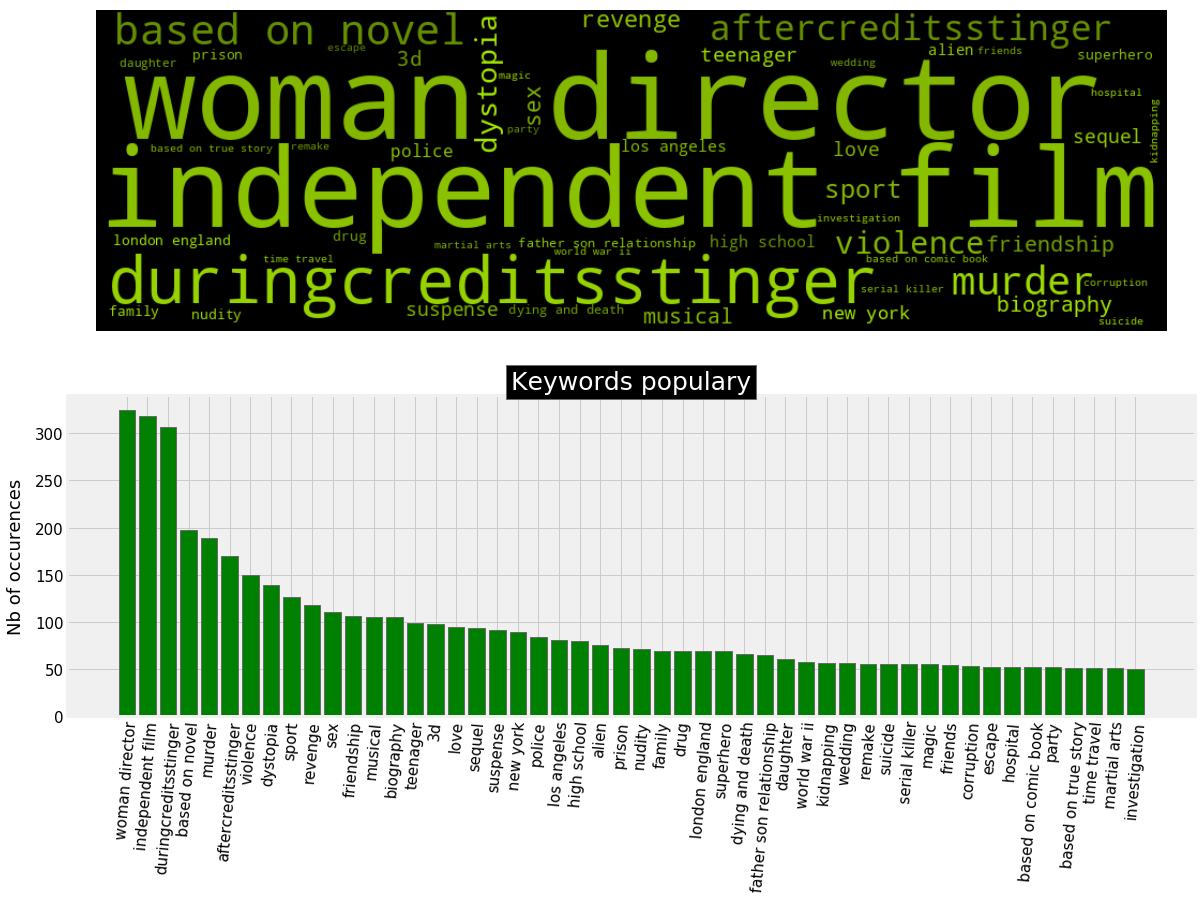

In [9]:
# 函数控制词的颜色
# 警告：看不懂 the scope of variables is used to get the value of the "tone" variable
# I could not find the way to pass it as a parameter of "random_color_func()"
def random_color_func(word=None, font_size=None, position=None, orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0/ 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0) # random_state.randint是什么?
    return "hsl({}, {}%, {}%)".format(h, s, l)

# 上层：词云
fig = plt.figure(1, figsize=(18,13))
ax1 = fig.add_subplot(2, 1, 1)# 看不懂子图的配置


# 定义词典，用于制作赐予你就
words = dict()
trunc_occurences = keyword_occurences[0: 50]
for s in trunc_occurences:
    words[s[0]] = s[1]
tone = 55.0 #定义词的颜色

wordcloud = WordCloud(width=1000, height=300, background_color='black', max_words=1628, relative_scaling=1, 
                     color_func = random_color_func, normalize_plurals=False)
wordcloud.generate_from_frequencies(words)
ax1.imshow(wordcloud, interpolation='bilinear')
ax1.axis('off')

# 下层：直方图
ax2 = fig.add_subplot(2, 1, 2)
y_axis = [i[1] for i in trunc_occurences]
x_axis = [k for k, i in enumerate(trunc_occurences)]
x_label = [i[0] for i in trunc_occurences]
plt.xticks(rotation=85, fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(x_axis, x_label)
plt.ylabel("Nb of occurences", fontsize = 18, labelpad = 10)
ax2.bar(x_axis, y_axis, align = 'center', color='g')

plt.title("Keywords populary", bbox={'facecolor':'k', 'pad':5}, color='w', fontsize = 25)
plt.show()

# 1.2 填充元素：缺失值


In [10]:
missing_df = df_initial.isnull().sum(axis=0).reset_index() # 这句话的意思不理解
missing_df.columns = ['column_name', 'missing_count'] # column 与 columns的区别
missing_df['filling_factor'] = (df_initial.shape[0] - missing_df['missing_count']) / df_initial.shape[0] * 100
missing_df.sort_values('filling_factor').reset_index(drop = True)



,column_name,missing_count,filling_factor
0,homepage,3091,35.644389
1,tagline,844,82.427649
2,country,174,96.377264
3,actor_3_name,93,98.063710
4,language,86,98.209452
5,actor_2_name,63,98.688320
6,actor_1_name,53,98.896523
7,director_name,30,99.375390
8,overview,3,99.937539
9,duration,2,99.958359


## 1.3 每年上映的电影数目

In [11]:
df_initial['decade'] = df_initial['title_year'].apply(lambda x: ((x-1900) // 10) * 10) #为什么减去1900
# 函数作用：从一个分组对象中获取统计参数
def get_stats(gr):
    return {'min':gr.min(), 'max':gr.max(), 'count':gr.count(), 'mean':gr.mean()}

# 按照10年创建一个数据框包含这10年的统计信息
test = df_initial['title_year'].groupby(df_initial['decade']).apply(get_stats).unstack()# unstack有无括号的区别及作用


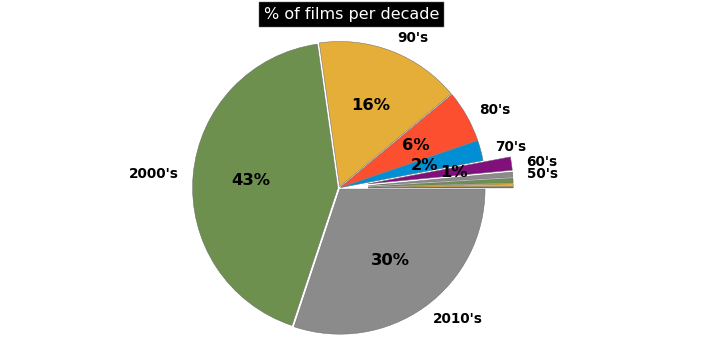

In [12]:
# 制作饼形图
sns.set_context("poster", font_scale=0.85)

# 设置标签
def label(s):
    val = (1900 + s, s)[s < 100]
    chaine = '' if s < 50 else "{}'s".format(int(val))
    return chaine

plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
labels = [label(s) for s in test.index]
sizes = test['count'].values
explode = [0.2 if sizes[i] < 100 else 0.01 for i in range(11)]
ax.pie(sizes, explode = explode, labels=labels, autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '', shadow=False, startangle=0)
ax.axis('equal')
ax.set_title('% of films per decade', bbox={'facecolor':'k', 'pad':5}, color='w', fontsize=16);
df_initial.drop('decade', axis=1, inplace = True)

# 1.4 类别
类别也需要流行度排行

In [13]:
genre_labels = set()
for s in df_initial['genres'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))

In [14]:
keyword_occurences, dum = count_word(df_initial, 'genres', genre_labels)
keyword_occurences[:5]

[['Drama', 2297],
 ['Comedy', 1722],
 ['Thriller', 1274],
 ['Action', 1154],
 ['Romance', 894]]

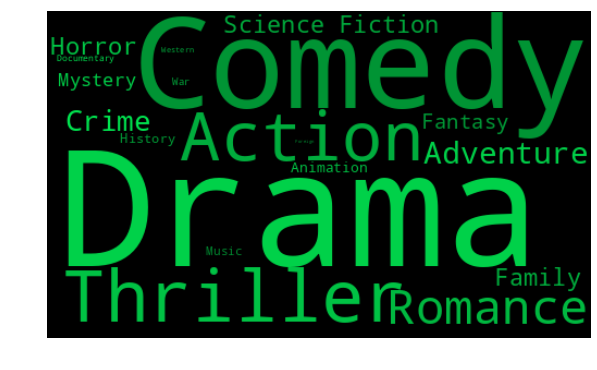

In [15]:
words = dict()
trunc_occurences = keyword_occurences[0:50]
for s in trunc_occurences:
    words[s[0]] = s[1]
tone = 100 # define the color of the words
f, ax = plt.subplots(figsize=(14, 6))
wordcloud = WordCloud(width=500, height=300, background_color='black',
                     max_words=1628, relative_scaling=0.7, color_func=random_color_func,
                     normalize_plurals=False)
wordcloud.generate_from_frequencies(words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# 2. 清洗
关键词是推荐系统引擎的重要角色。推荐系统给予电影之间的相似度来做推荐。找到使用相同关键词描述的电影。所以plot_keywords将会广泛用于相似度中

In [16]:
df_duplicate_cleaned = df_initial

# 2.1.1 词根分组
收集plot_keyword变量中的关键词。使用NLTK来清晰，最后看关键词的出现次数

In [17]:
# 收集关键词
def keywords_inventory(dataframe, colonne = 'plot_keywords'):
    PS = nltk.stem.PorterStemmer()
    keywords_roots = dict() # 收集词根
    keywords_select = dict() # 词根与关键词的关系
    category_keys = []
    icount = 0
    for s in dataframe[colonne]:
        if pd.isnull(s): continue # 这一句要深刻理解
        for t in s.split('|'):
            t = t.lower() ; racine = PS.stem(t) #lower是啥？ racine是啥? ;啥作用？
            if racine in keywords_roots:
                keywords_roots[racine].add(t)
            else:
                keywords_roots[racine] = {t}
    
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k; min_length = len(k)
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0]) #啥意思
            keywords_select[s] = list(keywords_roots[s])[0] #啥意思
            
    print("Nb of keywords in variable '{}': {}".format(colonne, len(category_keys)))
    return category_keys, keywords_roots, keywords_select

错误：TypeError:"None"type object is not iterable
1、None赋给多值  
2、函数返回值未考虑条件分支的覆盖  
3、没有return时，python默认返回None

In [18]:
keywords, keywords_roots, keywords_select = keywords_inventory(df_duplicate_cleaned, colonne = 'plot_keywords')
# 是如何清洗的？

Nb of keywords in variable 'plot_keywords': 9474


In [19]:
# 做一个关键词的示例。出现在最近关系的变量中的关键词
icount = 0
for s in keywords_roots.keys():
    if len(keywords_roots[s]) > 1:
        icount += 1
        if icount < 15: print(icount, keywords_roots[s], len(keywords_roots[s]))

1 {'alien', 'alienation'} 2
2 {'spying', 'spy'} 2
3 {'vigilantism', 'vigilante'} 2
4 {'terror', 'terrorism'} 2
5 {'flood', 'flooding'} 2
6 {'spider', 'spiders'} 2
7 {'horses', 'horse'} 2
8 {'musical', 'music'} 2
9 {'animal', 'animation', 'anime'} 3
10 {'compass', 'compassion'} 2
11 {'training', 'train'} 2
12 {'sailing', 'sail'} 2
13 {'time travel', 'time traveler'} 2
14 {'orc', 'orcs'} 2


In [20]:
# 使用主要的形式代表关键词
def remplacement_df_keywords(df, dico_remplacement, roots = False): # 啥意思
    df_new = df.copy(deep = True)
    for index, row in df_new.iterrows():
        chaine = row['plot_keywords']
        if pd.isnull(chaine): continue
        nouvelle_liste = []
        for s in chaine.split('|'):
            clef = PS.stem(s) if roots else s
            if clef in dico_remplacement.keys():
                nouvelle_liste.append(dico_remplacement[clef])
            else:
                nouvelle_liste.append(s)
        df_new.set_value(index, 'plot_keywords', '|'.join(nouvelle_liste))
    return df_new

In [21]:
# 使用主关键词替换关键词
df_keywords_cleaned = remplacement_df_keywords(df_duplicate_cleaned, keywords_select, roots = True)


In [22]:
# 记录关键词出现的次数
keywords.remove('')
keyword_occurences, keywords_count = count_word(df_keywords_cleaned, 'plot_keywords', keywords)
keyword_occurences[: 5]

[['woman director', 324],
 ['independent film', 318],
 ['duringcreditsstinger', 307],
 ['based on novel', 197],
 ['murder', 197]]

# 2.1.2 同义词分组
两步清晰关键词：1、压缩出现5次以下的关键词，用更高频率的关键词代替。2压缩在所有电影中出现次数少于3次的关键词

In [23]:
# 得到 mot_cle的关键词
def get_synonymes(mot_cle):
    lemma = set()
    for ss in wordnet.synsets(mot_cle):
        for w in ss.lemma_names():
            # 我们只需要名词
            index = ss.name().find('.') + 1
            if ss.name()[index] == 'n': lemma.add(w.lower().replace('_',' '))
    return lemma

In [24]:
# 完全看不懂 以alien为例
mot_cle = 'alien'
lemma = get_synonymes(mot_cle)
for s in lemma:
    print(' "{:<30}" in keywords list -> {} {}'.format(s, s in keywords, keywords_count[s] if s in keywords else 0))

 "unknown                       " in keywords list -> False 0
 "extraterrestrial              " in keywords list -> True 4
 "alien                         " in keywords list -> True 80
 "extraterrestrial being        " in keywords list -> False 0
 "foreigner                     " in keywords list -> False 0
 "noncitizen                    " in keywords list -> False 0
 "outlander                     " in keywords list -> False 0
 "stranger                      " in keywords list -> True 7


In [25]:
# 检查mot是否key_count中的键
def test_keyword(mot, key_count, threshold):
    return(False, True)[key_count.get(mot, 0) >= threshold]

In [26]:
keyword_occurences.sort(key = lambda x:x[1], reverse = False)
key_count = dict()
for s in keyword_occurences:
    key_count[s[0]] = s[1]
    
# 创建一个字典用高频次的次代替低频次的词
remplacement_mot = dict()
icount = 0
for index, [mot,nb_apparitions] in enumerate(keyword_occurences):
    if nb_apparitions > 5: continue #当频次大于5时，跳过
    lemma = get_synonymes(mot)
    if len(lemma) == 0: continue # 看不懂
    
    liste_mots = [(s, key_count[s]) for s in lemma if 
                  test_keyword(s, key_count, key_count[mot])]
    liste_mots.sort(key = lambda x:(x[1], x[0]), reverse = True)
    if len(liste_mots) <= 1:continue # 不替代
    if mot == liste_mots[0][0]: continue # 用自身替换 啥意思
    icount += 1
    if icount < 8:
        print('{:<12} -> {:<12} (init: {})'.format(mot, liste_mots[0][0], liste_mots))
    remplacement_mot[mot] = liste_mots[0][0]
    
print(90*'_'+'\n'+'The replacement concerns {}% of the keywords.'.
     format(round(len(remplacement_mot)/len(keywords)*100, 2)))

narcism      -> narcissism   (init: [('narcissism', 1), ('narcism', 1)])
apparition   -> shadow       (init: [('shadow', 3), ('phantom', 3), ('apparition', 1)])
macao        -> macau        (init: [('macau', 1), ('macao', 1)])
regent       -> trustee      (init: [('trustee', 1), ('regent', 1)])
civilization -> culture      (init: [('culture', 2), ('civilization', 1)])
ark          -> ark of the covenant (init: [('ark of the covenant', 2), ('ark', 1)])
automaton    -> zombie       (init: [('zombie', 45), ('robot', 27), ('automaton', 1)])
__________________________________________________________________________________________
The replacement concerns 6.0% of the keywords.


In [27]:
# 2 连续替换
print('Keywords that aapear both in keys and values:'.upper()+'\n'+45*'_')
icount = 0
for s in remplacement_mot.values():
    if s in remplacement_mot.keys():
        icount += 1
        if icount < 10: print('{:<20} -> {:<20}'.format(s, remplacement_mot[s]))
            
for key, value in remplacement_mot.items():
    if value in remplacement_mot.keys():
        remplacement_mot[key] = remplacement_mot[value]

KEYWORDS THAT AAPEAR BOTH IN KEYS AND VALUES:
_____________________________________________
shadow               -> dark                
failure              -> loser               
leech                -> parasite            
carnival             -> circus              
pit                  -> hell                
drawing              -> lottery             
deal                 -> mountain            
twist                -> crook               
pest                 -> plague              


In [28]:
# 使用主关键词替代关键词变量
df_keywords_synonyms = remplacement_df_keywords(df_keywords_cleaned, remplacement_mot, roots = False)
keywords, keywords_roots, keywords_select = keywords_inventory(df_keywords_synonyms, colonne = 'plot_keywords')

Nb of keywords in variable 'plot_keywords': 8907


In [29]:
# 新的关键词出现次数
keywords.remove('')
new_keyword_occurences, keywords_count = count_word(df_keywords_synonyms, 'plot_keywords', keywords)
new_keyword_occurences[:5]

[['woman director', 324],
 ['independent film', 318],
 ['duringcreditsstinger', 307],
 ['based on novel', 197],
 ['murder', 197]]

In [30]:
# 删除低频次的关键词
def remplacement_df_low_frequency_keywords(df, keyword_occurences):
    df_new = df.copy(deep = True)
    key_count = dict()
    for s in keyword_occurences:
        key_count[s[0]] = s[1]
    for index, row in df_new.iterrows():
        chaine = row['plot_keywords']
        if pd.isnull(chaine): continue
        nouvelle_liste = []
        for s in chaine.split('|'):
            if key_count.get(s, 4) > 3: nouvelle_liste.append(s)
        df_new.set_value(index, 'plot_keywords', '|'.join(nouvelle_liste))
    return df_new

In [31]:
# 创建一个低频次关键词压缩后的数据框
df_keywords_occurence = remplacement_df_low_frequency_keywords(df_keywords_synonyms, new_keyword_occurences)
keywords, keywords_roots, kyewords_select = keywords_inventory(df_keywords_occurence, colonne = 'plot_keywords')

Nb of keywords in variable 'plot_keywords': 2121


In [32]:
# 新的关键词数
keywords.remove('')
new_keyword_occurences, keywords_count = count_word(df_keywords_occurence, 'plot_keywords', keywords)
new_keyword_occurences[:5]

[['woman director', 324],
 ['independent film', 318],
 ['duringcreditsstinger', 307],
 ['based on novel', 197],
 ['murder', 197]]

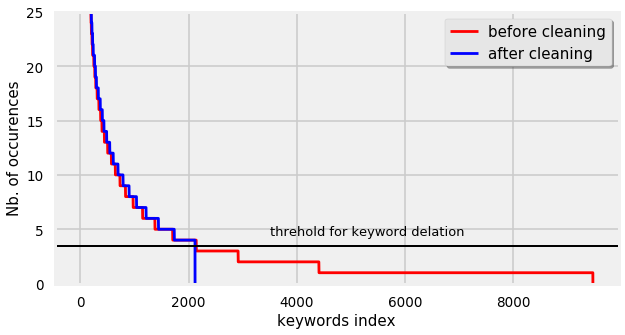

In [35]:
# 关键词出现次数画图
font = {'family': 'fantasy', 'weight': 'normal', 'size'    : 15} # 为什么这多空格
mpl.rc('font', **font)

keyword_occurences.sort(key = lambda x:x[1], reverse = True)

y_axis = [i[1] for i in keyword_occurences]
x_axis = [k for k, i in enumerate(keyword_occurences)]

new_y_axis = [i[1] for i in new_keyword_occurences]
new_x_axis = [k for k, i in enumerate(new_keyword_occurences)]

f, ax= plt.subplots(figsize=(9, 5))
ax.plot(x_axis, y_axis, 'r-', label = 'before cleaning')
ax.plot(new_x_axis, new_y_axis, 'b-', label = 'after cleaning')

# 增加图例
legend = ax.legend(loc='upper right', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
for label in legend.get_texts():
    label.set_fontsize('medium')
    
plt.ylim((0, 25))
plt.axhline(y=3.5, linewidth=2, color='k')
plt.xlabel("keywords index", family = 'fantasy', fontsize = 15)
plt.ylabel('Nb. of occurences', family = 'fantasy', fontsize = 15)
# plt.suptitle("Nombre d`occurences des mots cles", fontsize = 10, family = 'fantasy')
plt.text(3500, 4.5, 'threhold for keyword delation', fontsize = 13)
plt.show()

# 2.2 相关性
这个图 很牛掰！！！！要学会！！！  
根据相关性，删除一些变量 并重新排序列

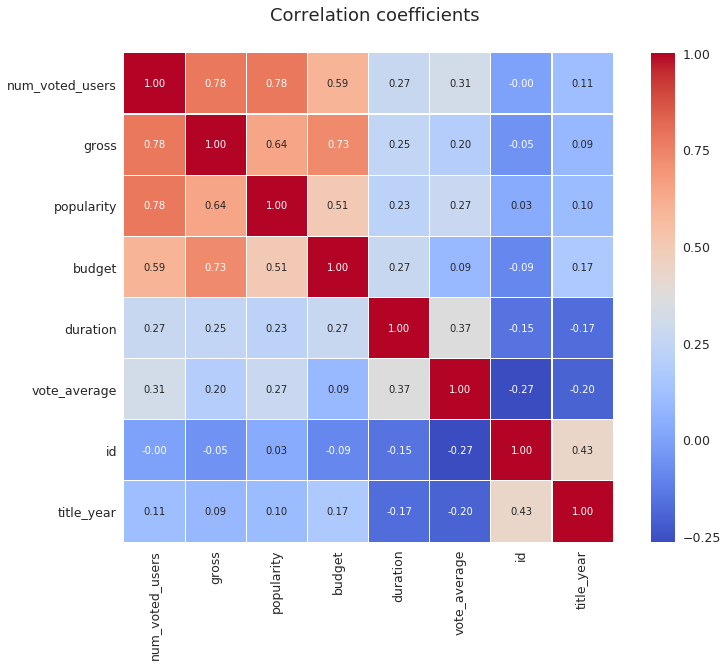

In [38]:
f, ax = plt.subplots(figsize=(12, 9))
# 计算相关性
corrmat = df_keywords_occurence.dropna(how='any').corr()

k = 17 # 热力图变量的个数
cols = corrmat.nlargest(k, 'num_voted_users')['num_voted_users'].index
cm = np.corrcoef(df_keywords_occurence[cols].dropna(how='any').values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True,
                fmt='.2f', annot_kws={'size': 10}, linewidth = 0.1, cmap='coolwarm',
                yticklabels=cols.values, xticklabels=cols.values)
f.text(0.5, 0.93, "Correlation coefficients", ha='center', fontsize = 18, family='fantasy')
plt.show()